# Coffee Shop Discrete-Event Simulation

This notebook models a coffee shop with multiple baristas serving customers using SimPy. It analyzes staffing levels and profitability under different configurations.

**Model:**
- Customers arrive according to a Poisson process with rate λ (customers per minute)
- Each barista serves customers one at a time with Exponential service times (mean service rate μ)
- If all baristas are busy, customers wait in a single first-come, first-served queue
- Simulation runs for 4 hours (240 minutes)


In [9]:
%pip install -q simpy numpy matplotlib scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

## CoffeeShop Class

The CoffeeShop class manages the simulation environment, baristas (as a SimPy Resource), and tracks statistics.


In [11]:
class CoffeeShop:
    """Coffee shop simulation environment with patience, menu items,
       skill-based service times, and linear arrival decay."""

    def __init__(self, env, num_baristas, base_service_rate, menu,
                patience_min, patience_max):
        self.env = env
        self.num_baristas = num_baristas

        self.menu = menu
        self.item_sales = {item[0]: 0 for item in self.menu}

        self.barista_skills = [
            random.uniform(0.75, 1.25) for _ in range(num_baristas)
        ]

        # Base service rate (per-minute)
        self.base_service_rate = base_service_rate

        # Resource
        self.baristas = simpy.Resource(env, capacity=num_baristas)

        # Stats
        self.waiting_times = []
        self.customers_served = 0
        self.total_service_time = 0.0
        self.revenue = 0.0
        self.abandoned = 0

        # Queue tracking
        self.queue_lengths = []

        # Patience
        self.patience_min = patience_min
        self.patience_max = patience_max

    def serve_customer(self, customer_id, arrival_time):
        """Process a customer's journey: queue, patience, service."""

        # Random patience
        patience = random.uniform(self.patience_min, self.patience_max)

        with self.baristas.request() as request:
            # Wait for barista OR leave early
            result = yield request | self.env.timeout(patience)

            if request not in result:
                # Customer abandoned queue
                self.abandoned += 1
                return

            # Wait time
            wait = self.env.now - arrival_time
            self.waiting_times.append(wait)

            # Customer picks a menu item
            item_name, price, modifier = random.choice(self.menu)

            self.item_sales[item_name] += 1

            # Pick a random barista skill (whoever becomes free)
            barista_skill = random.choice(self.barista_skills)

            # Effective service rate = base rate × skill
            effective_rate = self.base_service_rate * barista_skill

            # Mean service time modified by menu item
            mean_service = (1 / effective_rate) * modifier

            service_time = random.expovariate(1 / mean_service)

            self.total_service_time += service_time
            yield self.env.timeout(service_time)

            # Served
            self.customers_served += 1
            self.revenue += price

## Helper Functions


In [12]:
def customer_generator(env, coffee_shop, base_arrival_rate, hourly_pattern):
    customer_id = 0
    alpha = 0.04  # decay per customer in queue

    while True:
        queue_len = len(coffee_shop.baristas.queue)
        coffee_shop.queue_lengths.append((env.now, queue_len))

        hour = int(env.now // 60)
        hour = min(hour, len(hourly_pattern)-1)
        hour_multiplier = hourly_pattern[hour]

        # Effective arrival rate
        decay_factor = max(0.0, 1 - alpha * queue_len)
        λ_eff = base_arrival_rate * hour_multiplier * decay_factor

        if λ_eff <= 0:
            yield env.timeout(1)
            continue

        inter_arrival = random.expovariate(λ_eff)
        yield env.timeout(inter_arrival)

        customer_id += 1
        env.process(coffee_shop.serve_customer(customer_id, env.now))

def run_simulation(num_baristas, arrival_rate, service_rate, sim_time,
                   menu, patience_min, patience_max):
    env = simpy.Environment()
    shop = CoffeeShop(
        env,
        num_baristas,
        service_rate,
        menu,
        patience_min,
        patience_max
    )

    hourly_pattern = [0.6, 0.8, 1.0, 1.2]

    env.process(customer_generator(env, shop, arrival_rate, hourly_pattern))
    env.run(until=sim_time)

    avg_wait = np.mean(shop.waiting_times) if shop.waiting_times else 0
    utilization = min(100,
        shop.total_service_time / (num_baristas * sim_time) * 100
    )

    summary = {
        "avg_wait_time": avg_wait,
        "utilization": utilization,
        "customers_served": shop.customers_served,
        "revenue": shop.revenue,
        "abandoned": shop.abandoned,
        "baristas": num_baristas
    }

    return shop, summary

## Simulation Parameters

Modify these parameters to test different scenarios:


In [13]:
# Base parameters
arrival_rate = 0.5
service_rate = 0.25

sim_time = 240
time_hours = sim_time / 60.0

revenue_per_customer = None
wage_per_hour = 20

barista_counts = [1, 2, 3, 4, 5]

#patience
patience_min = 5
patience_max = 5

#menu items
menu = [
    ("Drip Coffee", 4, 0.8),
    ("Latte", 6, 1.0),
    ("Premium Mocha", 8, 1.3)
]

print("Parameters:")
print(f"Arrival rate: {arrival_rate}")
print(f"Service rate: {service_rate}")
print(f"Sim time: {sim_time} minutes")
print(f"Patience: {patience_min} minutes")

Parameters:
Arrival rate: 0.5
Service rate: 0.25
Sim time: 240 minutes
Patience: 5 minutes


## Run Simulations

Run the simulation for each barista count and collect results:


In [14]:
# Store results
results = []

print("Running coffee shop simulation...\n")

# Run simulation for each barista count
for num_baristas in barista_counts:
    print(f"Running simulation with {num_baristas} barista(s)...", end=" ")

    shop, summary = run_simulation(
        num_baristas=num_baristas,
        arrival_rate=arrival_rate,
        service_rate=service_rate,
        sim_time=sim_time,
        menu=menu,
        patience_min=patience_min,
        patience_max=patience_max
    )

    # Profit: total revenue - labor cost
    profit = summary["revenue"] - (num_baristas * wage_per_hour * time_hours)

    results.append({
        'baristas': num_baristas,
        'avg_wait_time': summary['avg_wait_time'],
        'utilization': summary['utilization'],
        'customers_served': summary['customers_served'],
        'abandoned': summary['abandoned'],
        'revenue': summary['revenue'],
        'profit': profit
    })
    
    print("Done!")

print("\nAll simulations complete!")

Running coffee shop simulation...

Running simulation with 1 barista(s)... Done!
Running simulation with 2 barista(s)... Done!
Running simulation with 3 barista(s)... Done!
Running simulation with 4 barista(s)... Done!
Running simulation with 5 barista(s)... Done!

All simulations complete!


## Table 1. System performance metrics by number of baristas (λ = 0.5 customers/min)

In [15]:
# Print results table
print("="*80)
print("SIMULATION RESULTS")
print("="*80)
print(f"{'Baristas':<10} {'Avg Wait (min)':<18} {'Utilization (%)':<18} "
      f"{'Profit ($)':<15} {'Customers Served':<20}")
print("-"*80)

for r in results:
    print(f"{r['baristas']:<10} {r['avg_wait_time']:<18.2f} {r['utilization']:<18.2f} "
          f"{r['profit']:<15.2f} {r['customers_served']:<20}")

print("="*80)


SIMULATION RESULTS
Baristas   Avg Wait (min)     Utilization (%)    Profit ($)      Customers Served    
--------------------------------------------------------------------------------
1          2.41               85.57              262.00          55                  
2          1.27               70.88              346.00          89                  
3          0.52               53.22              360.00          101                 
4          0.09               48.97              298.00          100                 
5          0.27               47.25              300.00          121                 


## Figure 1. Profit vs Number of Baristas (λ = 0.5 customers/min)

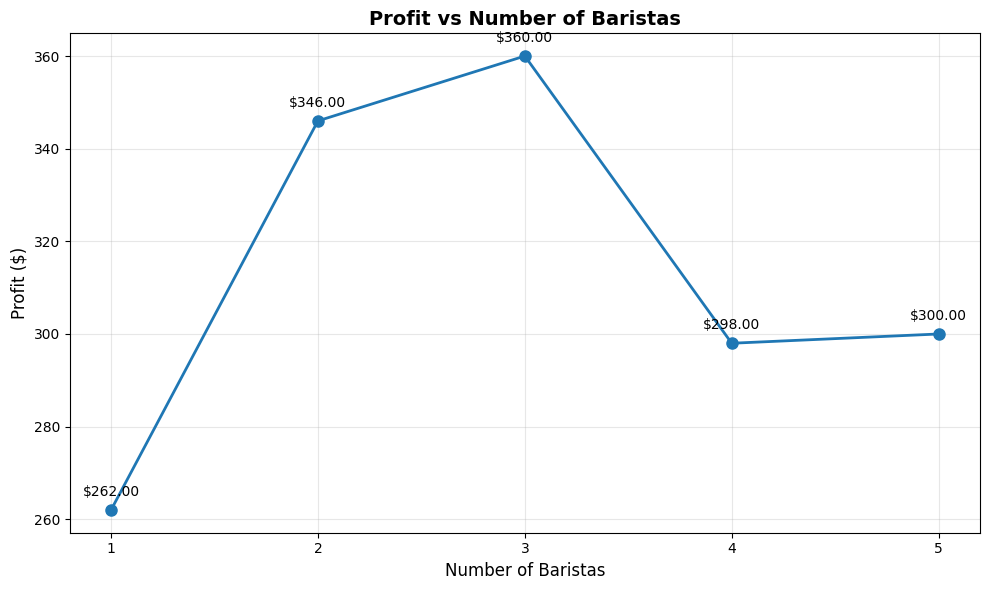

In [16]:
# Plot Profit vs Number of Baristas
baristas = [r['baristas'] for r in results]
profits = [r['profit'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(baristas, profits, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Baristas', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.title('Profit vs Number of Baristas', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(baristas)

# Add value labels on points
for b, p in zip(baristas, profits):
    plt.annotate(f'${p:.2f}', (b, p), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Figure 2. Impact of customer patience time on system performance: customers served and abandoned, abandonment rate, average wait time, and throughput (λ = 0.5 customers/min, 2 baristas).

COFFEE SHOP SIMULATION WITH CUSTOMER PATIENCE

Simulation Setup:
  - Arrival rate: 0.5 customers/min
  - Service rate: 0.25 per minute
  - Number of baristas: 2
  - Simulation time: 240 minutes

Testing patience times: [5, 10, 15, 20, 25, 30] minutes

Running with patience time = 5 min... Done!
Running with patience time = 10 min... Done!
Running with patience time = 15 min... Done!
Running with patience time = 20 min... Done!
Running with patience time = 25 min... Done!
Running with patience time = 30 min... Done!

RESULTS
Patience   Served     Abandoned    Abandon %    Avg Wait     Utilization %  
------------------------------------------------------------------------------------------
5          90         35           28.00        1.79         80.43          
10         108        6            5.26         3.80         91.75          
15         101        6            5.61         5.41         96.00          
20         95         9            8.65         7.56         85.75     

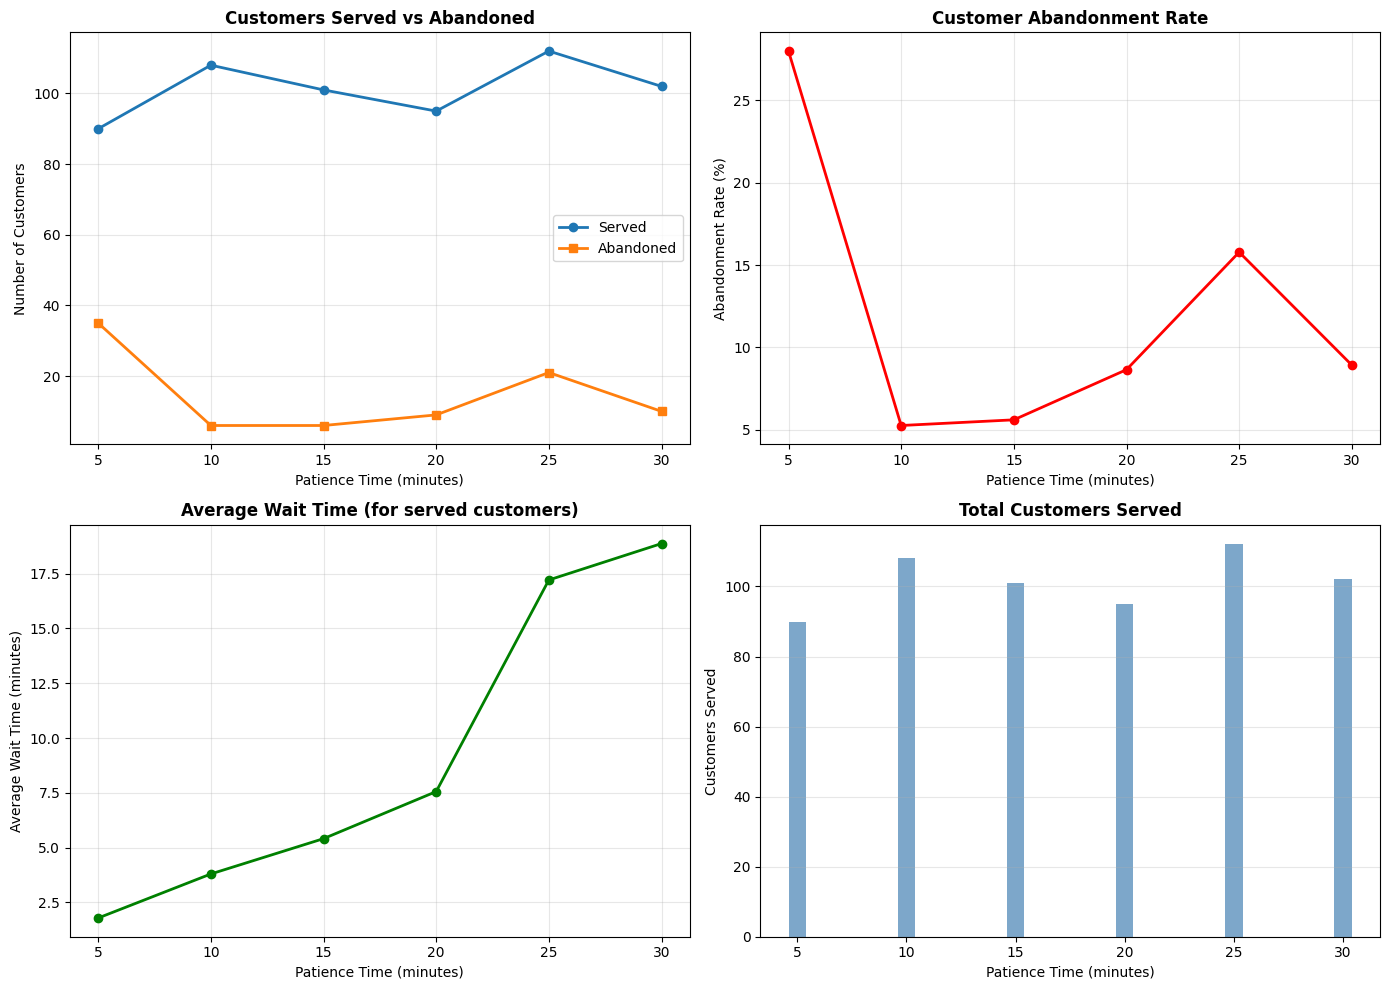


Key Insights:
  - With very low patience (5 min), many customers abandon
  - As patience increases, more customers are served
  - Average wait time for served customers may increase with patience
  - This simulation helps optimize service level vs customer expectations


In [17]:
# Standalone Simulation with Customer Patience Time

import simpy
import random
import numpy as np

def patient_customer(env, customer_id, arrival_time, baristas, service_rate, patience_time, stats):
    """
    Customer process with patience - leaves queue if wait exceeds patience time.
    
    Args:
        env: SimPy environment
        customer_id: Unique customer identifier
        arrival_time: Time when customer arrives
        baristas: SimPy Resource representing baristas
        service_rate: Service rate (μ)
        patience_time: Maximum time customer will wait before leaving
        stats: Dictionary to track statistics
    """
    with baristas.request() as request:
        # Start waiting
        queue_entry_time = env.now
        
        # Wait for barista or timeout if patience runs out
        result = yield request | env.timeout(patience_time)
        
        # Check if we got a barista or timed out
        if request in result:
            # Got a barista! Calculate wait time
            wait_time = env.now - arrival_time
            stats['waiting_times'].append(wait_time)
            
            # Generate and process service time
            service_time = random.expovariate(service_rate)
            stats['total_service_time'] += service_time
            
            yield env.timeout(service_time)
            
            # Customer served successfully
            stats['customers_served'] += 1
        else:
            # Patience ran out - customer leaves
            stats['customers_abandoned'] += 1
            stats['abandon_times'].append(env.now - arrival_time)


def patient_customer_generator(env, baristas, arrival_rate, service_rate, patience_time, stats):
    """Generate customers with patience."""
    customer_id = 0
    while True:
        # Generate inter-arrival time
        inter_arrival_time = random.expovariate(arrival_rate)
        yield env.timeout(inter_arrival_time)
        
        # Create new customer with patience
        customer_id += 1
        arrival_time = env.now
        env.process(patient_customer(env, customer_id, arrival_time, baristas, 
                                     service_rate, patience_time, stats))


def run_patience_simulation(num_baristas, arrival_rate, service_rate, patience_time, sim_time):
    """Run simulation with customer patience."""
    # Create environment
    env = simpy.Environment()
    
    # Create baristas resource
    baristas = simpy.Resource(env, capacity=num_baristas)
    
    # Statistics dictionary
    stats = {
        'waiting_times': [],
        'total_service_time': 0.0,
        'customers_served': 0,
        'customers_abandoned': 0,
        'abandon_times': []
    }
    
    # Start customer generator
    env.process(patient_customer_generator(env, baristas, arrival_rate, 
                                           service_rate, patience_time, stats))
    
    # Run simulation
    env.run(until=sim_time)
    
    # Calculate statistics
    avg_wait_time = np.mean(stats['waiting_times']) if stats['waiting_times'] else 0.0
    avg_abandon_time = np.mean(stats['abandon_times']) if stats['abandon_times'] else 0.0
    utilization = min(100.0, (stats['total_service_time'] / (num_baristas * sim_time)) * 100)
    abandonment_rate = (stats['customers_abandoned'] / 
                       (stats['customers_served'] + stats['customers_abandoned']) * 100) \
                       if (stats['customers_served'] + stats['customers_abandoned']) > 0 else 0.0
    
    return {
        'avg_wait_time': avg_wait_time,
        'utilization': utilization,
        'customers_served': stats['customers_served'],
        'customers_abandoned': stats['customers_abandoned'],
        'abandonment_rate': abandonment_rate,
        'avg_abandon_time': avg_abandon_time
    }


# Run simulations with different patience times
print("="*90)
print("COFFEE SHOP SIMULATION WITH CUSTOMER PATIENCE")
print("="*90)

# Simulation parameters
arrival_rate = 0.5  # customers per minute
service_rate = 0.25  # service rate per minute
sim_time = 240  # 4 hours
num_baristas = 2  # Start with 2 baristas (high wait times scenario)

# Test different patience times
patience_times = [5, 10, 15, 20, 25, 30]  # minutes

print(f"\nSimulation Setup:")
print(f"  - Arrival rate: {arrival_rate} customers/min")
print(f"  - Service rate: {service_rate} per minute")
print(f"  - Number of baristas: {num_baristas}")
print(f"  - Simulation time: {sim_time} minutes")
print(f"\nTesting patience times: {patience_times} minutes\n")

# Run simulations
patience_results = []
for patience in patience_times:
    print(f"Running with patience time = {patience} min...", end=" ")
    result = run_patience_simulation(num_baristas, arrival_rate, service_rate, 
                                     patience, sim_time)
    result['patience_time'] = patience
    patience_results.append(result)
    print("Done!")

# Display results
print("\n" + "="*90)
print("RESULTS")
print("="*90)
print(f"{'Patience':<10} {'Served':<10} {'Abandoned':<12} {'Abandon %':<12} "
      f"{'Avg Wait':<12} {'Utilization %':<15}")
print("-"*90)

for r in patience_results:
    print(f"{r['patience_time']:<10} {r['customers_served']:<10} "
          f"{r['customers_abandoned']:<12} {r['abandonment_rate']:<12.2f} "
          f"{r['avg_wait_time']:<12.2f} {r['utilization']:<15.2f}")

print("="*90)

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

patience_vals = [r['patience_time'] for r in patience_results]
served = [r['customers_served'] for r in patience_results]
abandoned = [r['customers_abandoned'] for r in patience_results]
abandon_rates = [r['abandonment_rate'] for r in patience_results]
wait_times = [r['avg_wait_time'] for r in patience_results]

# Plot 1: Customers Served vs Abandoned
axes[0, 0].plot(patience_vals, served, marker='o', label='Served', linewidth=2)
axes[0, 0].plot(patience_vals, abandoned, marker='s', label='Abandoned', linewidth=2)
axes[0, 0].set_xlabel('Patience Time (minutes)', fontsize=10)
axes[0, 0].set_ylabel('Number of Customers', fontsize=10)
axes[0, 0].set_title('Customers Served vs Abandoned', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Abandonment Rate
axes[0, 1].plot(patience_vals, abandon_rates, marker='o', color='red', linewidth=2)
axes[0, 1].set_xlabel('Patience Time (minutes)', fontsize=10)
axes[0, 1].set_ylabel('Abandonment Rate (%)', fontsize=10)
axes[0, 1].set_title('Customer Abandonment Rate', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Average Wait Time
axes[1, 0].plot(patience_vals, wait_times, marker='o', color='green', linewidth=2)
axes[1, 0].set_xlabel('Patience Time (minutes)', fontsize=10)
axes[1, 0].set_ylabel('Average Wait Time (minutes)', fontsize=10)
axes[1, 0].set_title('Average Wait Time (for served customers)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total throughput (served customers)
axes[1, 1].bar(patience_vals, served, alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Patience Time (minutes)', fontsize=10)
axes[1, 1].set_ylabel('Customers Served', fontsize=10)
axes[1, 1].set_title('Total Customers Served', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - With very low patience ({patience_times[0]} min), many customers abandon")
print(f"  - As patience increases, more customers are served")
print(f"  - Average wait time for served customers may increase with patience")
print(f"  - This simulation helps optimize service level vs customer expectations")

## Figure 3. Effects of customer tolerance (balking) and patience on system performance: customer flow outcomes (served, balked, abandoned), loss rates, average wait time, and revenue impact (λ = 0.5 customers/min, 2 baristas, patience = 15 min).

COFFEE SHOP SIMULATION WITH CUSTOMER PATIENCE AND TOLERANCE (BALKING)

Simulation Setup:
  - Arrival rate: 0.5 customers/min (base rate)
  - Service rate: 0.25 per minute
  - Number of baristas: 2
  - Patience time: 15 minutes (fixed)
  - Simulation time: 240 minutes

Tolerance Coefficient (balking sensitivity):
  - 0.0 = No balking (everyone joins)
  - 0.1 = Low sensitivity
  - 0.5 = High sensitivity (balk easily)

Testing tolerance coefficients: [0.0, 0.1, 0.2, 0.3, 0.5]

Running with tolerance = 0.0... Done!
Running with tolerance = 0.1... Done!
Running with tolerance = 0.2... Done!
Running with tolerance = 0.3... Done!
Running with tolerance = 0.5... Done!

RESULTS
Tolerance  Arrivals   Served     Balked     Abandoned  Balk %     Abandon %  Total Loss %
----------------------------------------------------------------------------------------------------
0.0        132        116        0          13         0.00       9.85       9.85        
0.1        115        89         21      

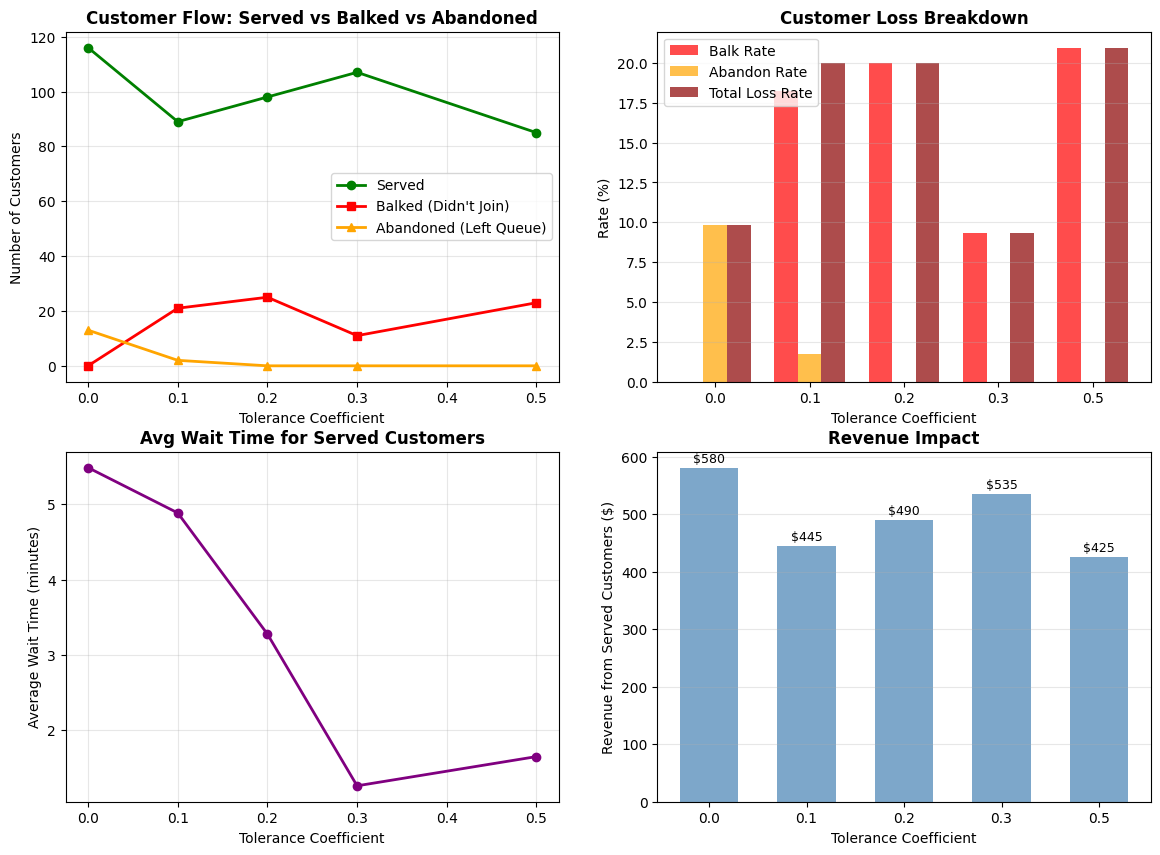

In [18]:
# Standalone Simulation with Customer Patience AND Tolerance (Balking)

import simpy
import random
import numpy as np

def patient_tolerant_customer(env, customer_id, arrival_time, baristas, service_rate, 
                               patience_time, stats):
    """
    Customer process with patience - leaves queue if wait exceeds patience time.
    (Only called if customer actually joins the queue)
    """
    with baristas.request() as request:
        # Start waiting
        queue_entry_time = env.now
        
        # Wait for barista or timeout if patience runs out
        result = yield request | env.timeout(patience_time)
        
        # Check if we got a barista or timed out
        if request in result:
            # Got a barista! Calculate wait time
            wait_time = env.now - arrival_time
            stats['waiting_times'].append(wait_time)
            
            # Generate and process service time
            service_time = random.expovariate(service_rate)
            stats['total_service_time'] += service_time
            
            yield env.timeout(service_time)
            
            # Customer served successfully
            stats['customers_served'] += 1
        else:
            # Patience ran out - customer leaves
            stats['customers_abandoned'] += 1


def tolerant_customer_generator(env, baristas, arrival_rate, service_rate, 
                                 patience_time, tolerance_coeff, stats):
    """
    Generate customers with tolerance - arrival rate decays with queue length.
    
    Balking probability: P(balk) = 1 - exp(-tolerance_coeff * queue_length)
    
    Args:
        tolerance_coeff: Controls sensitivity to queue length
                        - Higher value = more sensitive (more balking)
                        - Lower value = less sensitive (less balking)
    """
    customer_id = 0
    stats['arrival_attempts'] = 0
    
    while True:
        # Generate inter-arrival time (Poisson arrivals)
        inter_arrival_time = random.expovariate(arrival_rate)
        yield env.timeout(inter_arrival_time)
        
        customer_id += 1
        stats['arrival_attempts'] += 1
        arrival_time = env.now
        
        # Check current queue length
        queue_length = len(baristas.queue)
        
        # Calculate balking probability based on queue length
        # P(balk) = 1 - exp(-tolerance_coeff * queue_length)
        balk_probability = 1 - np.exp(-tolerance_coeff * queue_length)
        
        # Decide whether to join the queue or balk
        if random.random() < balk_probability:
            # Customer balks (doesn't join the queue)
            stats['customers_balked'] += 1
            stats['balk_queue_lengths'].append(queue_length)
        else:
            # Customer joins the queue
            env.process(patient_tolerant_customer(env, customer_id, arrival_time, 
                                                   baristas, service_rate, 
                                                   patience_time, stats))


def run_tolerance_simulation(num_baristas, arrival_rate, service_rate, 
                              patience_time, tolerance_coeff, sim_time):
    """Run simulation with both patience and tolerance (balking)."""
    # Create environment
    env = simpy.Environment()
    
    # Create baristas resource
    baristas = simpy.Resource(env, capacity=num_baristas)
    
    # Statistics dictionary
    stats = {
        'waiting_times': [],
        'total_service_time': 0.0,
        'customers_served': 0,
        'customers_abandoned': 0,
        'customers_balked': 0,
        'balk_queue_lengths': [],
        'arrival_attempts': 0
    }
    
    # Start customer generator
    env.process(tolerant_customer_generator(env, baristas, arrival_rate, 
                                            service_rate, patience_time, 
                                            tolerance_coeff, stats))
    
    # Run simulation
    env.run(until=sim_time)
    
    # Calculate statistics
    avg_wait_time = np.mean(stats['waiting_times']) if stats['waiting_times'] else 0.0
    avg_balk_queue = np.mean(stats['balk_queue_lengths']) if stats['balk_queue_lengths'] else 0.0
    utilization = min(100.0, (stats['total_service_time'] / (num_baristas * sim_time)) * 100)
    
    total_lost = stats['customers_abandoned'] + stats['customers_balked']
    total_customers = stats['arrival_attempts']
    
    balk_rate = (stats['customers_balked'] / total_customers * 100) if total_customers > 0 else 0.0
    abandon_rate = (stats['customers_abandoned'] / total_customers * 100) if total_customers > 0 else 0.0
    loss_rate = (total_lost / total_customers * 100) if total_customers > 0 else 0.0
    
    return {
        'avg_wait_time': avg_wait_time,
        'utilization': utilization,
        'customers_served': stats['customers_served'],
        'customers_abandoned': stats['customers_abandoned'],
        'customers_balked': stats['customers_balked'],
        'total_lost': total_lost,
        'balk_rate': balk_rate,
        'abandon_rate': abandon_rate,
        'loss_rate': loss_rate,
        'avg_balk_queue': avg_balk_queue,
        'arrival_attempts': stats['arrival_attempts']
    }


# Run simulations with different tolerance coefficients
print("="*100)
print("COFFEE SHOP SIMULATION WITH CUSTOMER PATIENCE AND TOLERANCE (BALKING)")
print("="*100)

# Simulation parameters
arrival_rate = 0.5  # customers per minute (attempting to arrive)
service_rate = 0.25  # service rate per minute
sim_time = 240  # 4 hours
num_baristas = 2
patience_time = 15  # Fixed patience: 15 minutes

# Test different tolerance coefficients
# Higher tolerance = more sensitive to queue length = more balking
tolerance_coeffs = [0.0, 0.1, 0.2, 0.3, 0.5]

print(f"\nSimulation Setup:")
print(f"  - Arrival rate: {arrival_rate} customers/min (base rate)")
print(f"  - Service rate: {service_rate} per minute")
print(f"  - Number of baristas: {num_baristas}")
print(f"  - Patience time: {patience_time} minutes (fixed)")
print(f"  - Simulation time: {sim_time} minutes")
print(f"\nTolerance Coefficient (balking sensitivity):")
print(f"  - 0.0 = No balking (everyone joins)")
print(f"  - 0.1 = Low sensitivity")
print(f"  - 0.5 = High sensitivity (balk easily)")
print(f"\nTesting tolerance coefficients: {tolerance_coeffs}\n")

# Run simulations
tolerance_results = []
for tol in tolerance_coeffs:
    print(f"Running with tolerance = {tol:.1f}...", end=" ")
    result = run_tolerance_simulation(num_baristas, arrival_rate, service_rate, 
                                      patience_time, tol, sim_time)
    result['tolerance'] = tol
    tolerance_results.append(result)
    print("Done!")

# Display results
print("\n" + "="*100)
print("RESULTS")
print("="*100)
print(f"{'Tolerance':<10} {'Arrivals':<10} {'Served':<10} {'Balked':<10} "
      f"{'Abandoned':<10} {'Balk %':<10} {'Abandon %':<10} {'Total Loss %':<12}")
print("-"*100)

for r in tolerance_results:
    print(f"{r['tolerance']:<10.1f} {r['arrival_attempts']:<10} {r['customers_served']:<10} "
          f"{r['customers_balked']:<10} {r['customers_abandoned']:<10} "
          f"{r['balk_rate']:<10.2f} {r['abandon_rate']:<10.2f} {r['loss_rate']:<12.2f}")

print("="*100)

# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

tolerance_vals = [r['tolerance'] for r in tolerance_results]
served = [r['customers_served'] for r in tolerance_results]
balked = [r['customers_balked'] for r in tolerance_results]
abandoned = [r['customers_abandoned'] for r in tolerance_results]
balk_rates = [r['balk_rate'] for r in tolerance_results]
abandon_rates = [r['abandon_rate'] for r in tolerance_results]
loss_rates = [r['loss_rate'] for r in tolerance_results]
wait_times = [r['avg_wait_time'] for r in tolerance_results]

# Plot 1: Customer Flow Breakdown
axes[0, 0].plot(tolerance_vals, served, marker='o', label='Served', linewidth=2, color='green')
axes[0, 0].plot(tolerance_vals, balked, marker='s', label='Balked (Didn\'t Join)', linewidth=2, color='red')
axes[0, 0].plot(tolerance_vals, abandoned, marker='^', label='Abandoned (Left Queue)', linewidth=2, color='orange')
axes[0, 0].set_xlabel('Tolerance Coefficient', fontsize=10)
axes[0, 0].set_ylabel('Number of Customers', fontsize=10)
axes[0, 0].set_title('Customer Flow: Served vs Balked vs Abandoned', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Loss Rates Comparison
x = np.arange(len(tolerance_vals))
width = 0.25
axes[0, 1].bar(x - width, balk_rates, width, label='Balk Rate', color='red', alpha=0.7)
axes[0, 1].bar(x, abandon_rates, width, label='Abandon Rate', color='orange', alpha=0.7)
axes[0, 1].bar(x + width, loss_rates, width, label='Total Loss Rate', color='darkred', alpha=0.7)
axes[0, 1].set_xlabel('Tolerance Coefficient', fontsize=10)
axes[0, 1].set_ylabel('Rate (%)', fontsize=10)
axes[0, 1].set_title('Customer Loss Breakdown', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'{t:.1f}' for t in tolerance_vals])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Average Wait Time (for served customers)
axes[1, 0].plot(tolerance_vals, wait_times, marker='o', color='purple', linewidth=2)
axes[1, 0].set_xlabel('Tolerance Coefficient', fontsize=10)
axes[1, 0].set_ylabel('Average Wait Time (minutes)', fontsize=10)
axes[1, 0].set_title('Avg Wait Time for Served Customers', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: System Efficiency (Revenue Impact)
revenue_per_customer = 5
served_revenue = [s * revenue_per_customer for s in served]

# Use x-axis positions (indices) instead of actual tolerance values for better bar alignment
x_pos = np.arange(len(tolerance_vals))
axes[1, 1].bar(x_pos, served_revenue, alpha=0.7, color='steelblue', width=0.6)
axes[1, 1].set_xlabel('Tolerance Coefficient', fontsize=10)
axes[1, 1].set_ylabel('Revenue from Served Customers ($)', fontsize=10)
axes[1, 1].set_title('Revenue Impact', fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'{t:.1f}' for t in tolerance_vals])
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (pos, rev) in enumerate(zip(x_pos, served_revenue)):
    axes[1, 1].text(pos, rev + 10, f'${rev:.0f}', ha='center', fontsize=9)

## Figure 4. Median profit by number of baristas from 1,000 Monte Carlo simulations per staffing level, with a fitted trendline highlighting the profit-maximizing staffing choice.

Running 1000-run Monte Carlo visualization...

Monte Carlo runs complete! Building visualization...



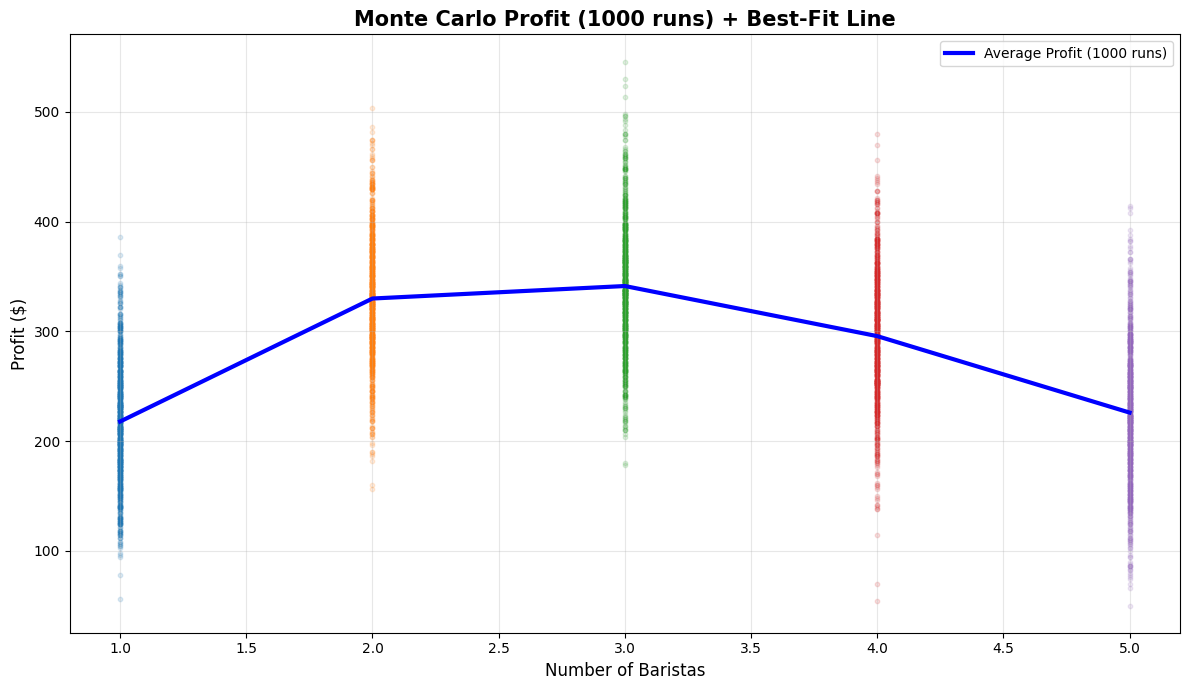

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression

print("Running 1000-run Monte Carlo visualization...\n")

num_runs = 1000
all_results = {b: [] for b in barista_counts}

for run_idx in range(num_runs):
    for num_baristas in barista_counts:
        shop, summary = run_simulation(
            num_baristas=num_baristas,
            arrival_rate=arrival_rate,
            service_rate=service_rate,
            sim_time=sim_time,
            menu=menu,
            patience_min=patience_min,
            patience_max=patience_max
        )

        profit = summary["revenue"] - (num_baristas * wage_per_hour * time_hours)
        all_results[num_baristas].append(profit)

print("Monte Carlo runs complete! Building visualization...\n")

# ----- Compute averages -----
avg_profits = {b: np.mean(all_results[b]) for b in barista_counts}

# ----- Prepare regression -----
X = np.array(barista_counts).reshape(-1, 1)
y = np.array([avg_profits[b] for b in barista_counts])

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# ----- Plot results -----
plt.figure(figsize=(12, 7))

# Scatter of all runs
for b in barista_counts:
    plt.scatter(
        [b] * num_runs,
        all_results[b],
        alpha=0.15,
        s=10,
    )

# Plot average line
plt.plot(
    barista_counts,
    [avg_profits[b] for b in barista_counts],
    color="blue",
    label="Average Profit (1000 runs)",
    linewidth=3
)


plt.xlabel("Number of Baristas", fontsize=12)
plt.ylabel("Profit ($)", fontsize=12)
plt.title("Monte Carlo Profit (1000 runs) + Best-Fit Line", fontsize=15, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Figure 5 + Figure 6

Running optimal-barista Monte Carlo sweep...

λ=0.10 → tested up to 9 baristas → best=1
λ=0.36 → tested up to 9 baristas → best=2
λ=0.62 → tested up to 9 baristas → best=3
λ=0.87 → tested up to 9 baristas → best=5
λ=1.13 → tested up to 9 baristas → best=6
λ=1.39 → tested up to 9 baristas → best=6
λ=1.65 → tested up to 9 baristas → best=8
λ=1.91 → tested up to 9 baristas → best=9
📈 Profit increasing at boundary → expanding to 14 baristas

λ=1.91 → tested up to 14 baristas → best=9
λ=2.16 → tested up to 9 baristas → best=9
📈 Profit increasing at boundary → expanding to 14 baristas

λ=2.16 → tested up to 14 baristas → best=10
λ=2.42 → tested up to 9 baristas → best=9
📈 Profit increasing at boundary → expanding to 14 baristas

λ=2.42 → tested up to 14 baristas → best=11
λ=2.68 → tested up to 9 baristas → best=9
📈 Profit increasing at boundary → expanding to 14 baristas

λ=2.68 → tested up to 14 baristas → best=13
λ=2.94 → tested up to 9 baristas → best=9
📈 Profit increasing at boundary → e

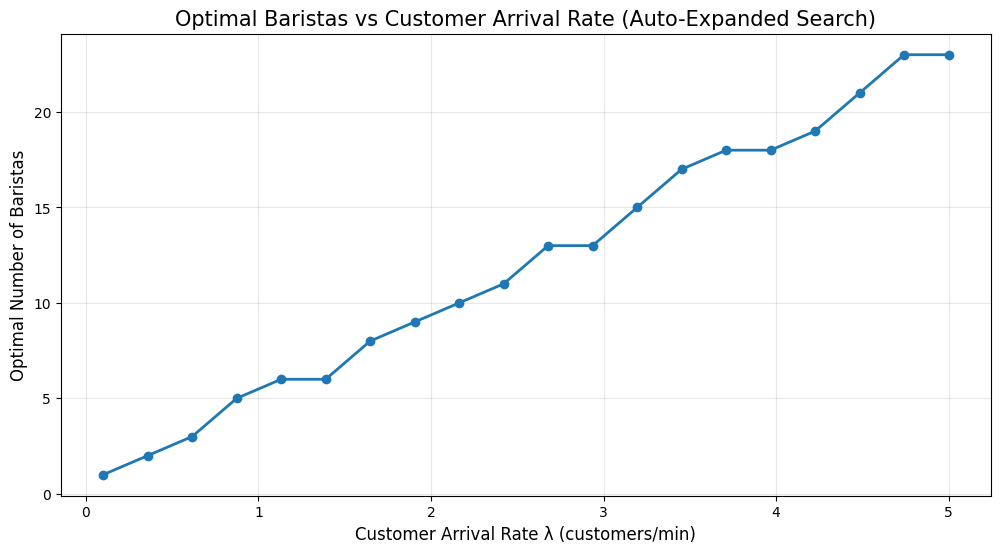

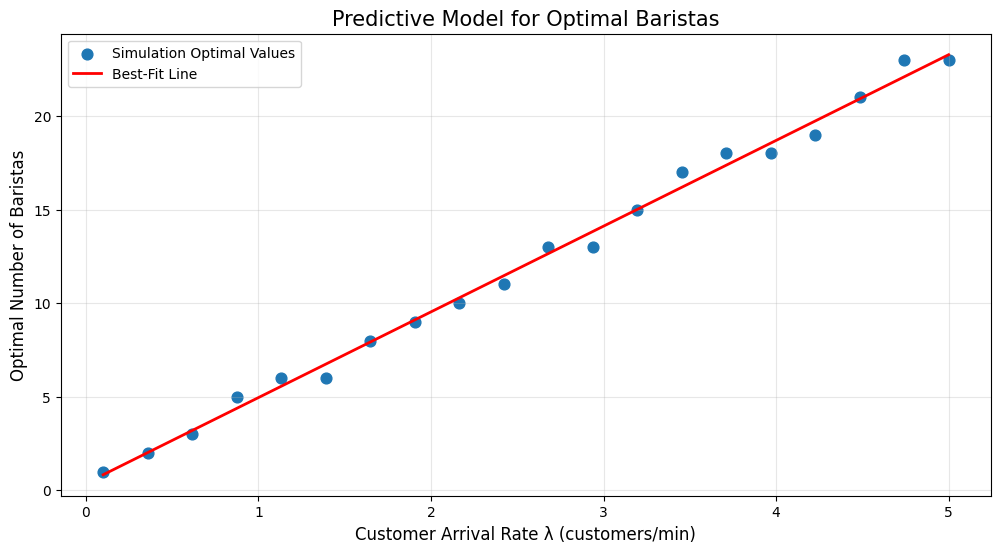


Best-fit linear model:
Optimal Baristas ≈ 4.580 * λ + 0.371


In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ===== FUNCTION: Auto-expand barista range until optimum found =====
def find_optimal_baristas_for_rate(
    arrival_rate,
    initial_max_baristas=9,
    num_runs=100,
    expansion_factor=1.5,
    max_cap=40  # absolute safety cap
):
    curr_max = initial_max_baristas
    prev_best = -np.inf

    while True:
        barista_range = list(range(1, curr_max + 1))
        expected_profits = {b: [] for b in barista_range}

        # Monte Carlo sims
        for _ in range(num_runs):
            for b in barista_range:
                shop, summary = run_simulation(
                    num_baristas=b,
                    arrival_rate=arrival_rate,
                    service_rate=service_rate,
                    sim_time=sim_time,
                    menu=menu,
                    patience_min=patience_min,
                    patience_max=patience_max
                )
                profit = summary["revenue"] - (b * wage_per_hour * time_hours)
                expected_profits[b].append(profit)

        # Avg profit curve
        avg_profits = {b: np.mean(expected_profits[b]) for b in barista_range}

        # Best barista count in current range
        best_b = max(avg_profits, key=lambda b: avg_profits[b])
        best_profit = avg_profits[best_b]

        print(f"λ={arrival_rate:.2f} → tested up to {curr_max} baristas → best={best_b}")

        # If optimum is not the boundary → DONE
        if best_b < curr_max:
            return best_b, avg_profits

        # If optimum is at the boundary → expand range
        if best_b == curr_max:
            if curr_max >= max_cap:
                print("⚠ Hit max cap; returning boundary value.")
                return best_b, avg_profits

            new_max = min(int(curr_max * expansion_factor) + 1, max_cap)
            print(f"📈 Profit increasing at boundary → expanding to {new_max} baristas\n")
            curr_max = new_max


# ===== MASTER SWEEP =====
arrival_rates = np.linspace(0.1, 5.0, 20)
num_runs = 100

optimal_baristas = []
avg_profits_map = {}

print("Running optimal-barista Monte Carlo sweep...\n")

for λ in arrival_rates:
    best_b, avg_profit_curve = find_optimal_baristas_for_rate(
        arrival_rate=λ,
        initial_max_baristas=9,
        num_runs=num_runs
    )
    optimal_baristas.append(best_b)
    avg_profits_map[λ] = avg_profit_curve

print("\nSweep complete! Now plotting...")


# ===== PLOT 1: Arrival rate vs optimal baristas =====
plt.figure(figsize=(12, 6))
plt.plot(arrival_rates, optimal_baristas, marker='o', linewidth=2)
plt.xlabel("Customer Arrival Rate λ (customers/min)", fontsize=12)
plt.ylabel("Optimal Number of Baristas", fontsize=12)
plt.title("Optimal Baristas vs Customer Arrival Rate (Auto-Expanded Search)", fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()


# ===== PLOT 2: Best-fit predictive model =====
X = arrival_rates.reshape(-1, 1)
y = np.array(optimal_baristas)

model = LinearRegression().fit(X, y)
pred = model.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(arrival_rates, optimal_baristas, s=60, label="Simulation Optimal Values")
plt.plot(arrival_rates, pred, color="red", linewidth=2, label="Best-Fit Line")

plt.xlabel("Customer Arrival Rate λ (customers/min)", fontsize=12)
plt.ylabel("Optimal Number of Baristas", fontsize=12)
plt.title("Predictive Model for Optimal Baristas", fontsize=15)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nBest-fit linear model:")
print(f"Optimal Baristas ≈ {model.coef_[0]:.3f} * λ + {model.intercept_:.3f}")